# **IEEE-CIS Fraud Detection**

**Install libraries** 

In [2]:
!pip install pyfiglet
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 865 kB 8.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/function')

# **Importation des librairies**

In [5]:
import numpy             as np # linear algebra
import pandas            as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn           as sns
import matplotlib.pyplot as plt
import opendatasets      as od
import functions
import warnings
import pyfiglet
import gc


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from imblearn.over_sampling    import SMOTE
from sklearn.preprocessing     import StandardScaler
from sklearn.svm               import SVC
from sklearn.linear_model      import LogisticRegression
from sklearn.ensemble          import RandomForestClassifier
from sklearn.model_selection   import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, KFold, cross_validate
from sklearn.metrics           import accuracy_score
from sklearn.preprocessing     import RobustScaler
from sklearn.preprocessing     import LabelEncoder
from sklearn.ensemble          import VotingClassifier
from sklearn.ensemble          import StackingClassifier
from sklearn                   import preprocessing



In [6]:
ascii_banner = pyfiglet.figlet_format("PyFraudPredict models")
print(ascii_banner)

 ____        _____                    _ ____               _ _      _   
|  _ \ _   _|  ___| __ __ _ _   _  __| |  _ \ _ __ ___  __| (_) ___| |_ 
| |_) | | | | |_ | '__/ _` | | | |/ _` | |_) | '__/ _ \/ _` | |/ __| __|
|  __/| |_| |  _|| | | (_| | |_| | (_| |  __/| | |  __/ (_| | | (__| |_ 
|_|    \__, |_|  |_|  \__,_|\__,_|\__,_|_|   |_|  \___|\__,_|_|\___|\__|
       |___/                                                            
                     _      _     
 _ __ ___   ___   __| | ___| |___ 
| '_ ` _ \ / _ \ / _` |/ _ \ / __|
| | | | | | (_) | (_| |  __/ \__ \
|_| |_| |_|\___/ \__,_|\___|_|___/
                                  



**Suppression des Warnings**

In [6]:
warnings.simplefilter("ignore")

# **Récupération du dataset**

In [7]:
url="https://www.kaggle.com/c/ieee-fraud-detection/data"
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abakamousa
Your Kaggle Key: ··········


100%|██████████| 118M/118M [00:01<00:00, 83.3MB/s]



Extracting archive ./ieee-fraud-detection/ieee-fraud-detection.zip to ./ieee-fraud-detection


**Chargement des différents dataset**

In [8]:
%%time
sample              = pd.read_csv("ieee-fraud-detection/sample_submission.csv")
df_identity         = pd.read_csv("ieee-fraud-detection/train_identity.csv")
df_transaction      = pd.read_csv("ieee-fraud-detection/train_transaction.csv")
df_test_transaction = pd.read_csv("ieee-fraud-detection/test_transaction.csv")
df_test_identity    = pd.read_csv("ieee-fraud-detection/test_identity.csv")

CPU times: user 29.3 s, sys: 6.74 s, total: 36.1 s
Wall time: 37.8 s


**Merge train and test data**

In [9]:
train = df_transaction.merge(df_identity, how="left", on="TransactionID")
test  = df_test_transaction.merge(df_test_identity, how="left", on="TransactionID")

**Reduction de la mémoire**

In [10]:
%%time
sample    = functions.reduce_mem_usage(sample)
train     = functions.reduce_mem_usage(train)
test      = functions.reduce_mem_usage(test)

Mem. usage decreased to  2.90 Mb (62.5% reduction)
Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)
CPU times: user 2min 17s, sys: 7.4 s, total: 2min 25s
Wall time: 2min 30s


In [11]:
gc.collect()

50

# **1- Analyse exploratoire**





**Sample dataset**

In [12]:
sample.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  506691 non-null  int32  
 1   isFraud        506691 non-null  float16
dtypes: float16(1), int32(1)
memory usage: 2.9 MB


In [15]:
sample.head(3)

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5


In [17]:
sample['isFraud'].unique()

array([0.5], dtype=float16)

**Remarque:**  La variable cible "isFraud" du dataset "sample_submission" se compose uniquement de la valeur 0.5. Ceci rend ce dataset inutilisable en dehors de la compétation kaggle.

**Train dataset**

In [18]:
print("Train dataset identity")
train.head(5)

Train dataset identity


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 650.5+ MB


In [28]:
train.describe(include="all")

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540,590540.000000,590540.0,590540.0,590540,590540.0,...,590540.0,590540.0,590540.0,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,439670,NaN,NaN,NaN,384767,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.282270e+06,0.034990,7.372311e+06,NaN,NaN,9898.734658,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,109.817924,247.600342,162.151215,18.372952,42.073849,28.327173
std,1.704744e+05,0.183755,4.617224e+06,NaN,NaN,4901.170153,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,2269.937256,3979.767822,2792.922363,331.834015,473.212738,381.324371
min,2.987000e+06,0.000000,8.640000e+04,0.250977,NaN,1000.000000,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,NaN,6019.000000,204.0,150.0,NaN,166.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,NaN,9678.000000,360.0,150.0,NaN,226.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,NaN,14184.000000,512.0,150.0,NaN,226.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
train.shape

(590540, 434)

In [22]:
print("Nombre d'observation ayant des valeurs manquantes: ", train.isnull().any(axis = 1).sum())

Nombre d'observation ayant des valeurs manquantes: 590540


**Remarque:** Chaque observation contient au moins une valeur manquante

In [25]:
print("Nombre de features ayant des valeurs manquantes: ", train.isnull().any(axis = 0).sum())

Nombre de features ayant des valeurs manquantes:  414


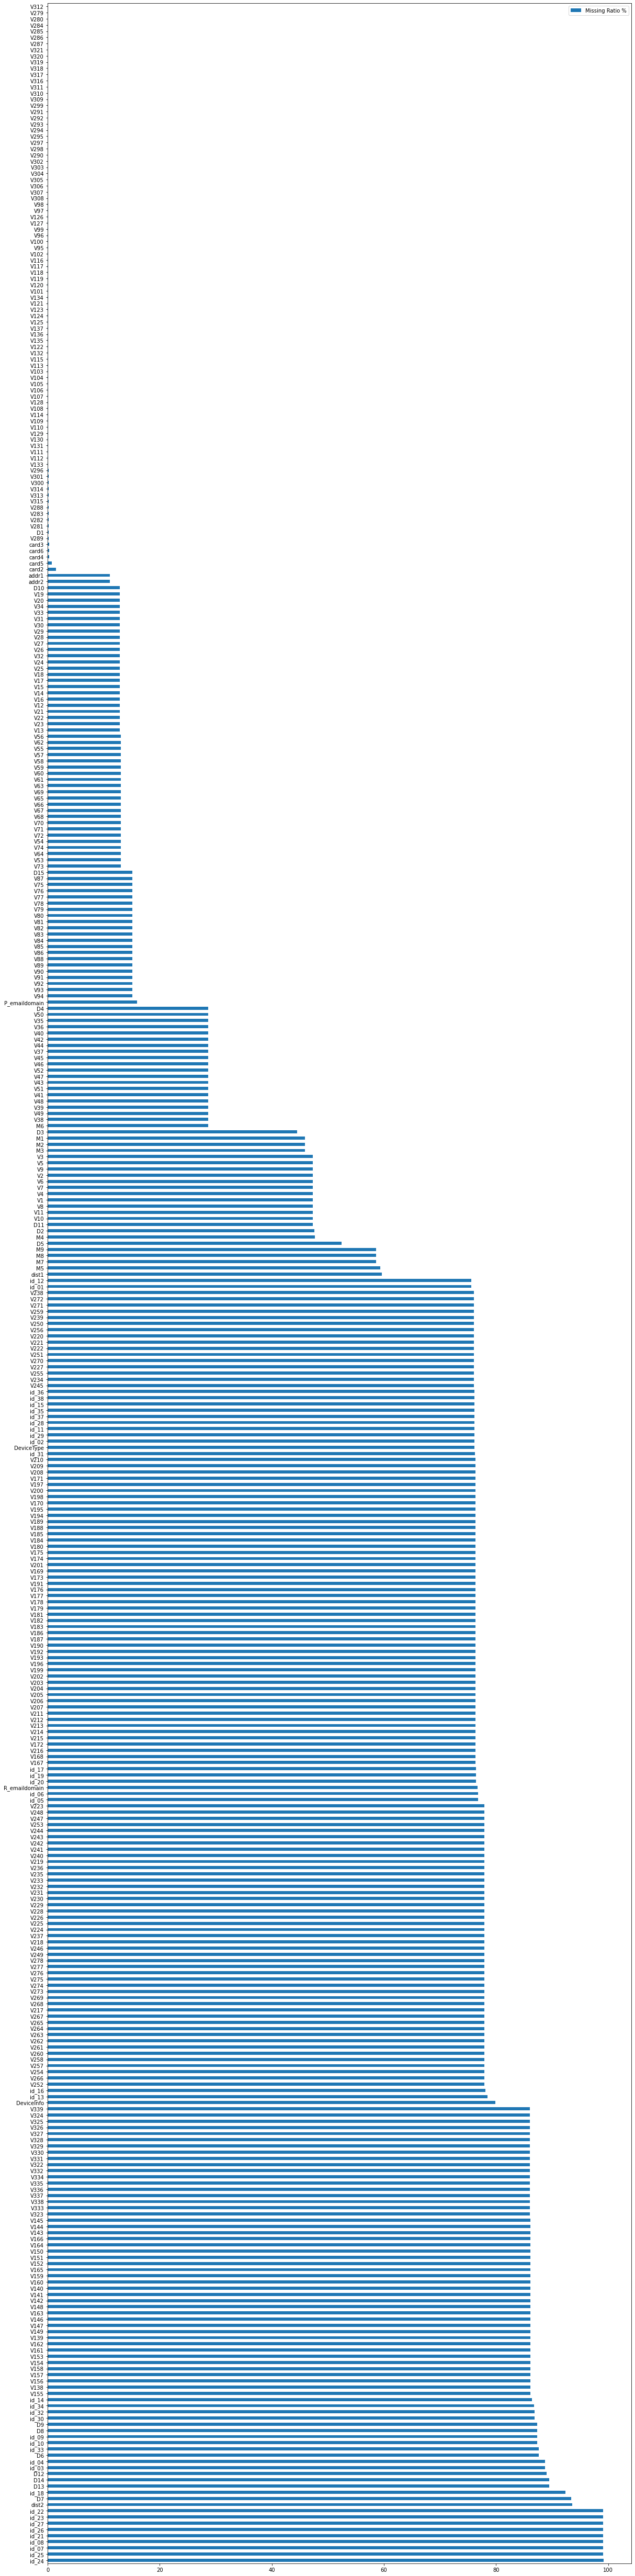

In [15]:
plot_width, plot_height = (20,90)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
functions.plot_nas(train)

**Elimination des features ayant plus de 75% de valeurs manquantes**

In [13]:
treshold = 75.0
min_count =  int(((100-treshold)/100)*train.shape[0] + 1)
train = train.dropna( axis=1, 
                thresh=min_count)

In [18]:
print("Nombre de valeurs manquantes dans la train dataset: ", train.isnull().sum().sum())

Nombre de valeurs manquantes dans la train dataset:  16088043


**Imputation des valeurs manquantes**

In [14]:
%%time
train = functions.fill_miss_val(train)

Nombre de valeur manquantes après l'imputation:  0
CPU times: user 2min 14s, sys: 13.7 s, total: 2min 28s
Wall time: 2min 14s


In [15]:
gc.collect()

50

In [21]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,0.0,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Boxplot d'un sous ensemble de features du train dataset**

In [24]:
train.shape

(590540, 226)

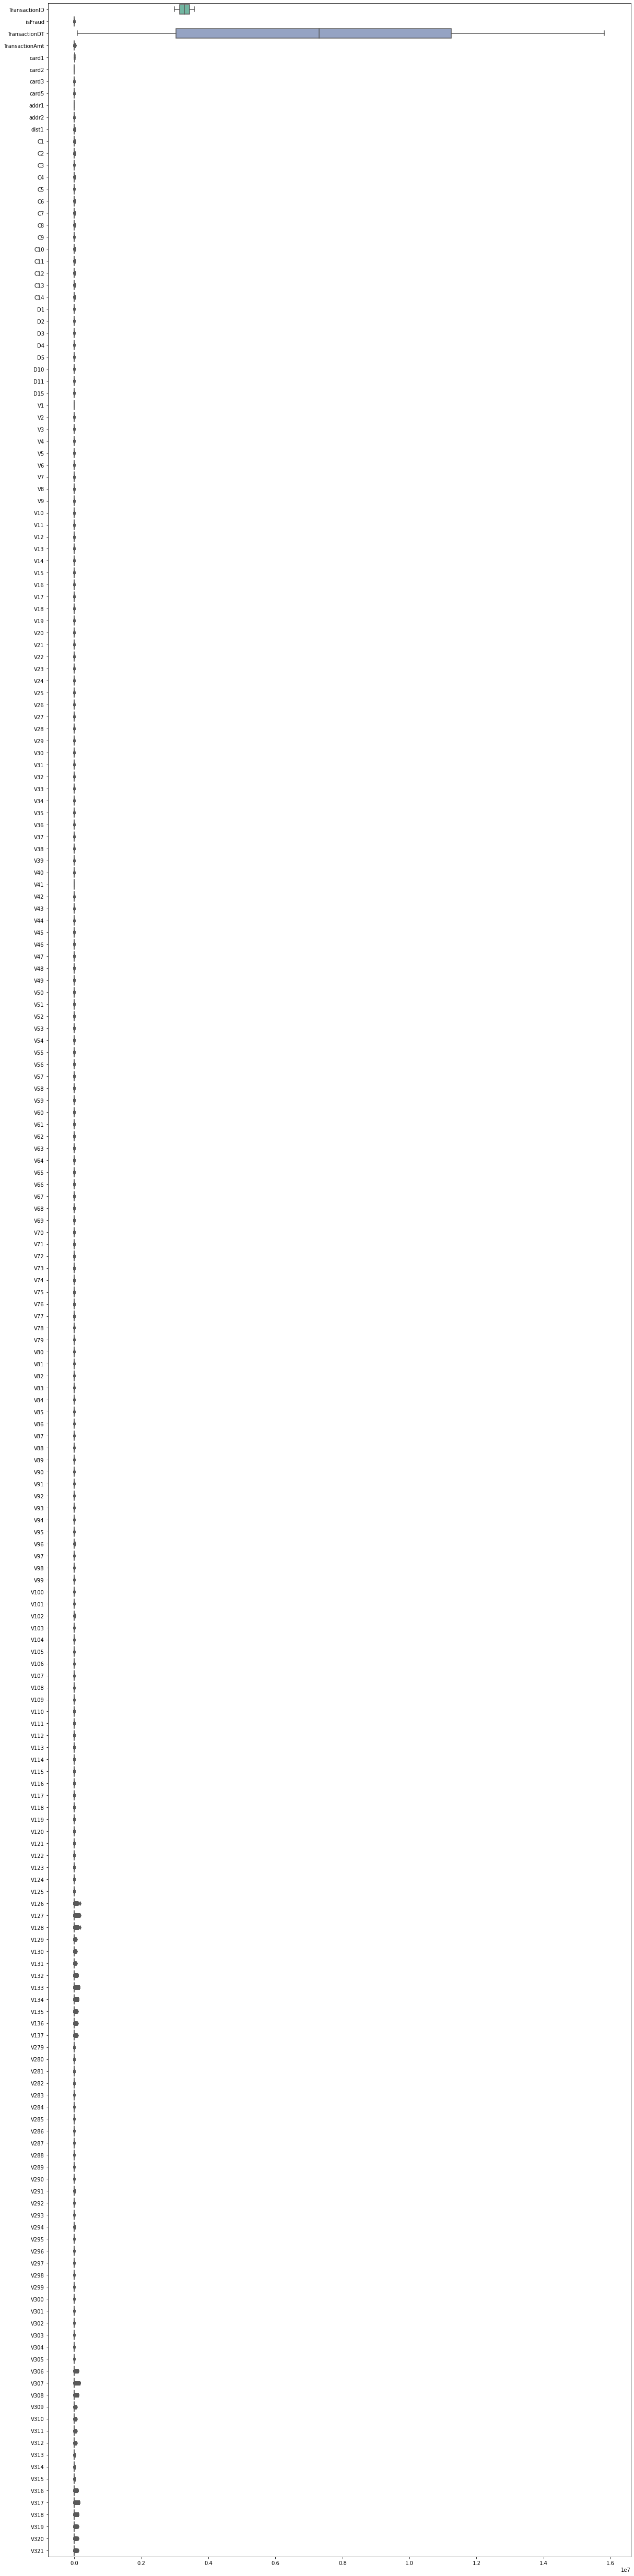

In [25]:
sns.boxplot(data=train, orient="h", palette="Set2")

**Remarque:** Ce graphe nous montre qu'il y'a pas d'outlier dans le train

**Histogram**

CPU times: user 17.5 s, sys: 422 ms, total: 17.9 s
Wall time: 18.5 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a6f512ad0>,
      dtype=object)

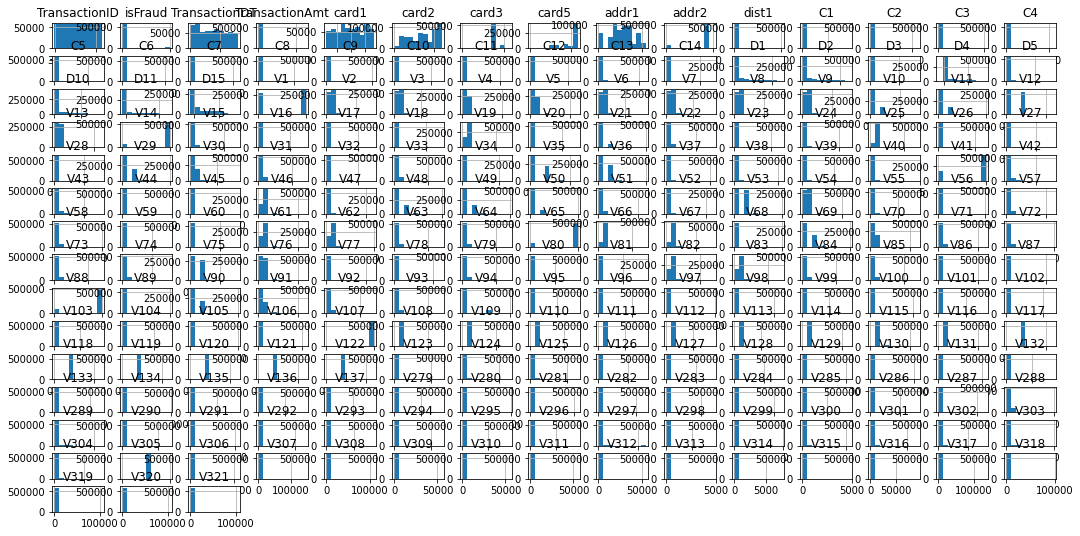

In [16]:
%%time
train.hist(figsize=(18,9))

**Analyse de la variable cible**

In [16]:
train['isFraud'].value_counts(normalize=True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

**Remarque:** Nous constatons ici que le train dataset contient pratiquement 96% d'observations non frauduleuse. Nous sommes donc face à un dataset contenant des classes déséquilibrés. Un modèle basé sur ce dataset est susceptible de produire un modèle biaisé. Par la suite, il faudra donc reéchantillonné le dataset pour pouvoir obtenir un modèle avec des prédictions non biaisés.  

**Encodage des valeurs categorielle**

In [17]:
gc.collect()

222

In [18]:
train = functions.encode_df(train)

**Analyse de la correlation**

In [19]:
# correlation matrix
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Suppression des features 
train.drop(to_drop, axis=1, inplace=True)

In [20]:
gc.collect()

50

In [21]:
train.shape

(590540, 241)

**Test dataset**

In [38]:
test.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
if ('isFraud' not in test.columns) and ('isFraud' not in test.columns):
    print(" Le dataframe de test ne contient pas de la variable cible 'isFraud'. Ceci rend ce dataframe inutilisable dans le cadre de notre projet.\n\n Pour la suite, nous allons donc utiliser principalement les dataframe Train")

 Le dataframe de test ne contient pas de la variable cible 'isFraud'. Ceci rend ce dataframe inutilisable dans le cadre de notre projet.

 Pour la suite, nous allons donc utiliser principalement les dataframe Train


**Train test split**

In [22]:
feats  = train.drop('isFraud', axis=1)
target = train.isFraud
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.25)

In [23]:
gc.collect()

152

**Features selection**

In [24]:
X_train_fs, X_test_fs = functions.select_features(X_train, y_train, X_test)

In [25]:
gc.collect()

149

**Features scaling**

In [26]:
#feature scaling with robustScaler
transformer = RobustScaler().fit(X_train_fs)
X_train = transformer.transform(X_train_fs)
X_test  = transformer.transform(X_test_fs)

In [27]:
gc.collect()

300

**Dataset resampling with SMOTE**

In [28]:
#Dataset resampling with SMOTE: 
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

Classes échantillon SMOTE : {0: 427332, 1: 427332}


In [29]:
gc.collect()

100

# **2- Entrainement et optimisation des hyperparamètres**

# A- Aprrentissage supervisé

**1- Lightgbm model**


In [30]:
# build the lightgbm model
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_sm, y_sm)

LGBMClassifier()

In [31]:
# predict the results
y_pred=clf.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score
accuracy_LightGBM=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_LightGBM))

LightGBM Model accuracy score: 0.9521


 **Compare train and test set accuracy**

This comparison of the train-set and test-set accuracy will allows to us to check  overfitting.

In [32]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9531
Test set score: 0.9534


**Note:** Le score (accuracy) obtenu en utilisant le train est presque similaire à celui obtenu avec le test dataset. Nous pouvons conclure que nous ne sommes pas en présence d'un cas d'overfitting 

**Lightgbm Hyperparameter optimization**

In [33]:
clf_lgb = lgb.LGBMClassifier()
params_lgb = {
    'num_leaves':[20,40,60,80,100,120,140,160,180,200,220,240,260,280,300], 
    'min_data_in_leaf':[200,300,400,500,600],
    'max_depth':[3,4,5,6,7,8,9,10,11,12],
    'learning_rate':[0.05,0.1,0.2],
}

gridcv_lgb = GridSearchCV(clf_lgb, param_grid=params_lgb, scoring='accuracy', cv=3)   

In [ ]:
gridcv_lgb.fit(X_sm, y_sm)

In [1]:
pd.DataFrame(gridcv_lgb.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

NameError: ignored

In [ ]:
gridcv_lgb.best_params_

In [ ]:
pred_lgb=gridcv_lgb.predict(X_test)

In [ ]:
print('Test set score: {:.4f}'.format(accuracy_score(y_test, pred_lgb)))

Test set score: 0.9815


In [ ]:
from sklearn.metrics import classification_report
print("Classication report for lightgbm: \n")
print(classification_report(y_test, pred_lgb))

Classication report for lightgbm: 

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       509
         1.0       0.92      0.74      0.82        31

    accuracy                           0.98       540
   macro avg       0.95      0.87      0.91       540
weighted avg       0.98      0.98      0.98       540



**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[507   2]
 [  6  25]]

True Positives(TP) =  507

True Negatives(TN) =  25

False Positives(FP) =  2

False Negatives(FN) =  6


**2- LogisticRegression, RandomForest and SVC**

In [ ]:
clf_lr = LogisticRegression(random_state=22, max_iter=2000)
clf_rf = RandomForestClassifier(random_state=22)
clf_svc = SVC(random_state=22)


param_grid_lr = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-4, 2, 9)}

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000], 
                  'min_samples_leaf': [1, 3, 5], 
                  'max_features': ['sqrt', 'log2']}]

param_grid_svc = [{'kernel': ['rbf'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},
                  {'kernel': ['linear'], 'C': np.logspace(-4, 4, 9)}]

In [ ]:
gridcvs ={}

for pgrid, clf, name in zip((param_grid_lr, param_grid_rf, param_grid_svc),
                            (clf_lr, clf_rf, clf_svc),
                            ('LogisticRegression', 'RF', 'SVM')):
    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True)
    gridcvs[name] = gcv

In [ ]:
outer_cv = StratifiedKFold(n_splits=3, shuffle=True)
outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_sm, y_sm, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

LogisticRegression: outer accuracy 97.74 +/- 0.70
RF: outer accuracy 99.02 +/- 0.28
SVM: outer accuracy 96.26 +/- 0.43


In [ ]:
svc_accuracy = gridcvs['SVM'].fit(X_sm, y_sm).score(X_test, y_test)
final_svc = gridcvs['SVM']
final_svc.fit(X_sm, y_sm)

print("Classication report for SVC: \n")
print(classification_report(y_test, final_svc.predict(X_test)))

Classication report for SVC: 

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       509
         1.0       0.44      0.65      0.53        31

    accuracy                           0.93       540
   macro avg       0.71      0.80      0.75       540
weighted avg       0.95      0.93      0.94       540



In [ ]:
lr_accuracy = gridcvs['LogisticRegression'].fit(X_sm, y_sm).score(X_test, y_test)
final_lr = gridcvs['LogisticRegression']
final_lr.fit(X_sm, y_sm)

print("Classication report for Logistic Regression: \n")
print(classification_report(y_test, final_lr.predict(X_test)))

/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Classication report for Logistic Regression: 

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       509
         1.0       0.51      0.71      0.59        31

    accuracy                           0.94       540
   macro avg       0.75      0.83      0.78       540
weighted avg       0.95      0.94      0.95       540



/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


**Note:** Nous allons sélectionner et entraîner le meilleur algorithme, celui avec le plus haut taux de bonne précision moyen et le plus faible écart-type

In [ ]:
final_clf = gridcvs['RF']
final_clf.fit(X_sm, y_sm)

print(f'Best Parameters: {final_clf.best_params_}')

train_rf_acc = accuracy_score(y_true=y_sm, y_pred=final_clf.predict(X_sm))
test_rf_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_rf_acc:.2f}')
print(f'Test Accuracy: {100*test_rf_acc:.2f}')

Best Parameters: {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 250}
Training Accuracy: 100.00
Test Accuracy: 97.22


In [ ]:
print("Classication report for random forest: \n")
print(classification_report(y_test, final_clf.predict(X_test)))

Classication report for random forest: 

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       509
         1.0       0.90      0.58      0.71        31

    accuracy                           0.97       540
   macro avg       0.94      0.79      0.85       540
weighted avg       0.97      0.97      0.97       540



**3- StackingClassifier**

In [ ]:
cv3 = KFold(n_splits=3, random_state=111, shuffle = True)

sclf = StackingClassifier(estimators=[('LR', clf_lr), ('rf', clf_rf), ('svc', clf_svc)], 
                          final_estimator= clf_svc)

scores = cross_validate(sclf, X_sm, y_sm, 
                                              cv=cv3, scoring=['accuracy','f1'])
print("[StackingClassifier]: \n Accuracy: %0.2f (+/- %0.2f)\n" 
      % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
      "F1 score: %0.2f (+/- %0.2f)"
      % (scores['test_f1'].mean(), scores['test_f1'].std()))


/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

[StackingClassifier]: 
 Accuracy: 0.99 (+/- 0.00)
 F1 score: 0.99 (+/- 0.00)


In [ ]:
sclf_accuracy = sclf.fit(X_sm, y_sm).score(X_test, y_test)

/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

In [ ]:
sclf_accuracy

0.9722222222222222

In [ ]:
print("Classication report for StackingClassifier : \n")
print(classification_report(y_test, sclf.predict(X_test)))

Classication report for StackingClassifier : 

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       509
         1.0       0.94      0.55      0.69        31

    accuracy                           0.97       540
   macro avg       0.96      0.77      0.84       540
weighted avg       0.97      0.97      0.97       540



**Comparaison des accuracy**

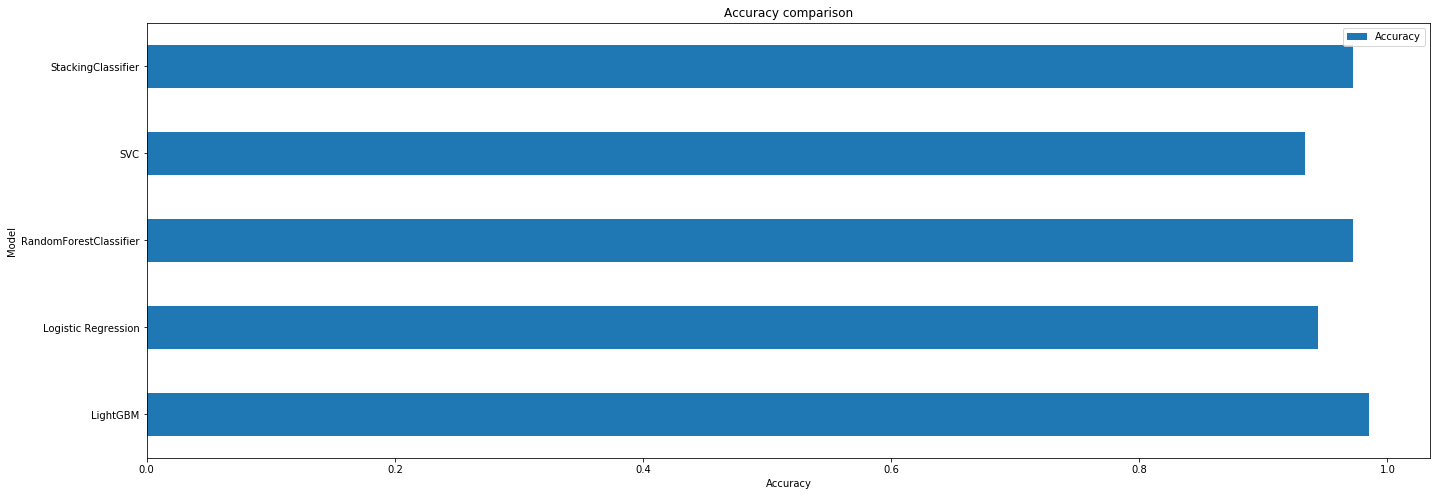

In [ ]:
data = {'Accuracy': [accuracy_LightGBM,lr_accuracy,test_rf_acc,svc_accuracy,sclf_accuracy]}
df_acc = pd.DataFrame(data,columns=['Accuracy'], index = ['LightGBM','Logistic Regression','RandomForestClassifier','SVC','StackingClassifier'])

df_acc.plot.barh()

plt.title('Accuracy comparison')
plt.ylabel('Model')
plt.xlabel('Accuracy')
plt.show()

**Note:** Nous constatons que les scores sont presque tous identiques

# B- Aprrentissage non supervisé

**1- Isolation forest**

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
clf_isolation=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.01),max_features=1.0)
clf_isolation.fit(X_sm)

IsolationForest(contamination=0.01, n_estimators=50)

In [ ]:
#['scores']=model.decision_function(df[['salary']])
#df['anomaly']=model.predict(df[['salary']])
#df.head(20)

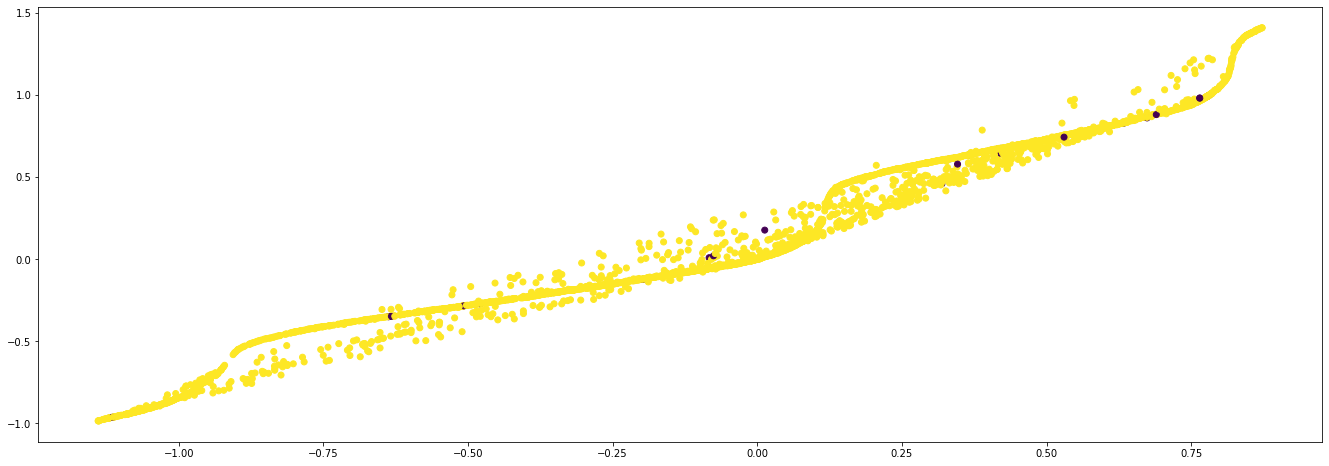

In [ ]:
plt.scatter(X_sm[:,0],X_sm[:,1], c=clf_isolation.predict(X_sm))

In [ ]:
data = {'Score':clf_isolation.decision_function(X_sm), 'Anomaly':clf_isolation.predict(X_sm)}  
dfIso = pd.DataFrame(data)  
dfIso.head(20)

,Score,Anomaly
0,0.155700,1
1,0.117756,1
2,0.158171,1
3,0.165566,1
4,0.138890,1
5,0.168290,1
6,0.156227,1
7,0.134936,1
8,0.165920,1
9,0.174086,1


In [ ]:
test_data =np.array(y_test)
dfPred = pd.DataFrame({ 'Pred': clf_isolation.predict(X_test)}, columns=['Pred'])
dfPred.head()

,Pred
0,1
1,1
2,1
3,1
4,1


In [ ]:
dfPred['Real'] = test_data

In [ ]:
dfPred.head()

,Pred,Real
0,1,0.0
1,1,0.0
2,1,0.0
3,1,0.0
4,1,0.0


In [ ]:
test_data.shape

(540,)

In [ ]:
y_test

8838    0.0
2440    0.0
6233    0.0
7727    0.0
608     0.0
       ... 
6165    0.0
8261    0.0
6305    0.0
2189    0.0
724     0.0
Name: isFraud, Length: 540, dtype: float64

In [ ]:
dfPred['Real'] = dfPred['Real'].replace([1,-1],[0,1])


In [ ]:
dfPred.value_counts()

Pred  Real
 1    0.0     531
-1    0.0       9
dtype: int64

In [ ]:
print("Classication report for isolation forest: \n")
print(classification_report(y_test, clf_isolation.predict(X_test)))

Classication report for isolation forest: 

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       509
         1.0       0.06      1.00      0.11        31

    accuracy                           0.06       540
   macro avg       0.02      0.33      0.04       540
weighted avg       0.00      0.06      0.01       540



/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aboubakar/anaconda3/lib/

 **2- Elliptic envelope**


In [ ]:
from sklearn.covariance import EllipticEnvelope

In [ ]:
clf_elliptic=EllipticEnvelope(contamination=0.03)
clf_elliptic.fit(X_sm)

/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


EllipticEnvelope(contamination=0.03)

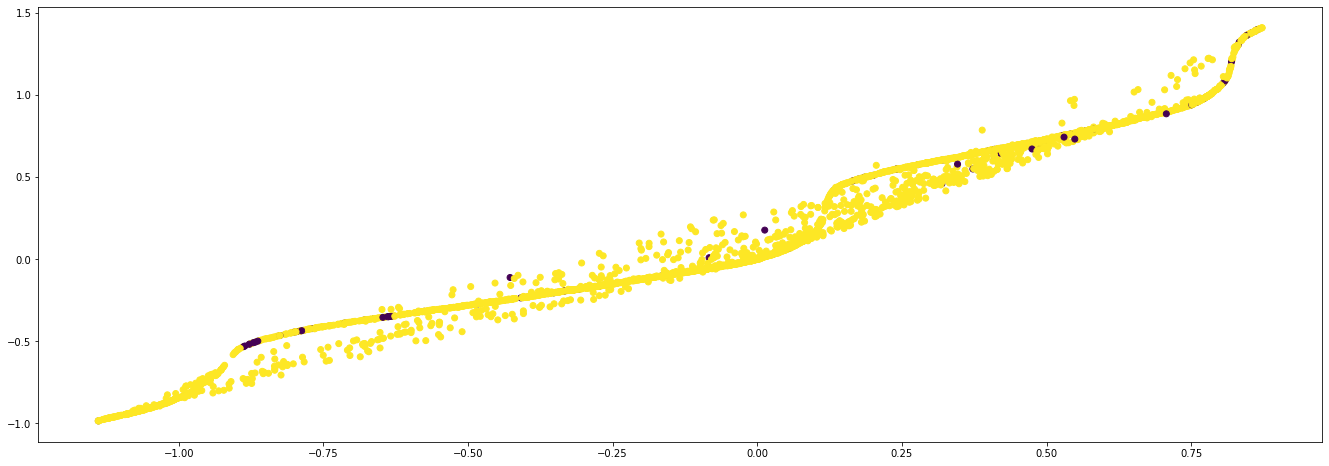

In [ ]:
plt.scatter(X_sm[:,0],X_sm[:,1], c=clf_elliptic.predict(X_sm))
plt.show()

In [ ]:
data_ = {'Score':clf_elliptic.decision_function(X_sm), 'Anomaly':clf_elliptic.predict(X_sm)}  
dfEl = pd.DataFrame(data)  
dfEl.head(20)

,Score,Anomaly
0,0.155700,1
1,0.117756,1
2,0.158171,1
3,0.165566,1
4,0.138890,1
5,0.168290,1
6,0.156227,1
7,0.134936,1
8,0.165920,1
9,0.174086,1


In [ ]:
dfPred_el = pd.DataFrame({ 'Pred': clf_elliptic.predict(X_test)}, columns=['Pred'])


dfPred_el['Real'] = test_data

dfPred_el.head()

,Pred,Real
0,1,0.0
1,1,0.0
2,1,0.0
3,1,0.0
4,1,0.0


In [ ]:
print("Classication report for isolation forest: \n")
print(classification_report(y_test, clf_elliptic.predict(X_test)))

Classication report for isolation forest: 

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       509
         1.0       0.06      0.97      0.11        31

    accuracy                           0.06       540
   macro avg       0.02      0.32      0.04       540
weighted avg       0.00      0.06      0.01       540



/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aboubakar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aboubakar/anaconda3/lib/

# **C- Compraison des performances**

# **3- Sauvegarde du model**

In [ ]:
from joblib import dump, load
import joblib

In [ ]:
# save the model to disk

In [ ]:
filename = 'finalized_model.sav'
joblib.dump(sclf, filename)


['finalized_model.sav']

In [ ]:
 # load the model from disk

In [ ]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.9722222222222222
